# Actor-critic methods

In this notebook, we will train a sophisticated RL agent for the [Lunar Lander](https://www.gymlibrary.dev/environments/box2d/lunar_lander/) environment using an actor-critic method called [A3C](https://cgnicholls.github.io/reinforcement-learning/2017/03/27/a3c.html).

The goal in Lunar Lander (as the name suggests) is to learn a policy to land a spaceship (a) safely and (b) in a desired location. Gravity pulls the ship down, so we need to slow it down by firing a main engine. We also need to steer the spaceship using the left and right engines.

##  Libraries

As always, let's load some libraries. We'll also need some special installations to work with the lunar lander environment.

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions
import matplotlib.pyplot as plt
import numpy as np
import gym
import moviepy.video.io.ImageSequenceClip
from moviepy.editor import *

In [21]:
# We may need the following code to use the lunar lander environment
!pip3 install pygame
!pip3 install box2d-py
!pip3 install gym[Box_2D]
!pip3 install imageio==2.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Defining the Model

Recall that in Actor-Critic methods we have two networks:

* an *Actor*, which is similar to the policy network we saw in Policy gradients
* a *Critic*, which learns the expected rewards using a Q-function.

Updates are performed using the same log-derivative trick as in policy gradients, but with the calculation of the reward function being performed by the critic. After each iteration both actor and critic are updated.


In [22]:
class ActorCritic(nn.Module):
    def __init__(self, actor, critic):
        super().__init__()
        
        self.actor = actor
        self.critic = critic
        
    def forward(self, state):
        
        action_pred = self.actor(state)
        value_pred = self.critic(state)
        
        return action_pred, value_pred

Let us set up the actor and critic networks as follows:

* the inputs are the state space variables,
* the output for the actor network are action space variables,
* the output for the critic network is the Q-value,
* there are two hidden layers of size 128, and
* each hidden neuron is a [parametric ReLU](https://pytorch.org/docs/stable/generated/torch.nn.PReLU.html) preceded by dropout.

Note that we will use the same network architecture for both actor and critic.


In [23]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout = 0.1):
        super().__init__()
        
        self.net = nn.Sequential(            
            nn.Linear(input_dim, hidden_dim),
            nn.Dropout(dropout),
            nn.PReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Dropout(dropout),
            nn.PReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        self.double()
        
    def forward(self, x):
        x = self.net(x)
        return x

# Training the model

Let us now train the model. Below are several helper functions. The reward calculation is identical to before. However, we will compute the ''advantage'' function for baseline adjustment. We will use the [smooth L1 loss](https://pytorch.org/docs/stable/generated/torch.nn.SmoothL1Loss.html) to prevent exploding gradients.

Updating is done by sampling an action from the distribution predicted by the actor network, and keeping track of the value function, the reward observed for that action, and the total episodic reward.

In [28]:
def calculate_returns(rewards, discount_factor, normalize = True):
    
    returns = []
    R = 0    
    for r in reversed(rewards):
        R = r + R * discount_factor
        returns.insert(0, R)
        
    returns = torch.tensor(returns)   
    if normalize:
        returns = (returns - returns.mean()) / returns.std()
    return returns

In [29]:
def calculate_advantages(returns, values, normalize = True):    
    advantages = returns - values
    if normalize:        
        advantages = (advantages - advantages.mean()) / advantages.std()
    return advantages

In [30]:
def update_policy(advantages, log_prob_actions, returns, values, optimizer):
        
    advantages = advantages.detach()
    returns = returns.detach()
        
    policy_loss = - (advantages * log_prob_actions).sum()
    value_loss = F.smooth_l1_loss(returns, values).sum()
        
    optimizer.zero_grad()
    policy_loss.backward()
    value_loss.backward()
    optimizer.step()
    
    return policy_loss.item(), value_loss.item()

In [31]:
def train(env, policy, optimizer, discount_factor):
    
    policy.train()
    
    log_prob_actions = []
    values = []
    rewards = []
    done = False
    episode_reward = 0

    state = env.reset()

    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).double()
        action_pred, value_pred = policy(state)
        action_prob = F.softmax(action_pred, dim=-1)

        dist = distributions.Categorical(action_prob)
        action = dist.sample()
        log_prob_action = dist.log_prob(action)

        state, reward, done, _ = env.step(action.item())
        log_prob_actions += [log_prob_action]
        values += [value_pred]
        rewards += [reward]

        episode_reward += reward
    
    log_prob_actions = torch.cat(log_prob_actions)
    values = torch.cat(values).squeeze(-1)
    
    returns = calculate_returns(rewards, discount_factor)
    advantages = calculate_advantages(returns, values)
    
    policy_loss, value_loss = update_policy(advantages, log_prob_actions, returns, values, optimizer)

    return policy_loss, value_loss, episode_reward

# Evaluating the model

Finally, we will also test the policy that we learned. Note that the procedure is similar to training except that we will not update the policy (either actor or critic) parameters. We could choose to pick the best action suggested by the policy but it turns out this gives worse performance (for most of the training process) than sampling from the distribution.

In [43]:
def evaluate(env, policy, return_frames=False):
    
    policy.eval()
    
    rewards = []
    done = False
    episode_reward = 0

    state = env.reset()
    frames = [] # Used for visualizing the agent play the game

    while not done:
        state = torch.FloatTensor(state).unsqueeze(0)
        state = state.double()

        if return_frames:
          frames += [env.render(mode="rgb_array")]

        with torch.no_grad():
        
            action_pred, _ = policy(state)
            action_prob = F.softmax(action_pred, dim=-1)
        
        action = action_prob.argmax()
                
        state, reward, done, _ = env.step(action.item())

        episode_reward += reward
        
    if return_frames:
      return episode_reward, frames

    return episode_reward

## Initialization and Training

In [ ]:
game_name = 'LunarLander-v2'
train_env = gym.make(game_name)
test_env = gym.make(game_name)

state_space_dim = train_env.observation_space.shape[0]
print(f'There are {state_space_dim} variables in the description of the observation space.')
print(f'There are {train_env.action_space} variables in the action space.')

action_space_dim = 4
HIDDEN_DIM = 128

actor = MLP(input_dim=state_space_dim, hidden_dim=HIDDEN_DIM, output_dim=action_space_dim)
critic = MLP(input_dim=state_space_dim, hidden_dim=HIDDEN_DIM, output_dim=1) 

policy = ActorCritic(actor, critic)
optimizer = optim.Adam(policy.parameters(), lr = 0.0005)

MAX_EPISODES = 1000
N_TRIALS = 25
REWARD_THRESHOLD = 200
PRINT_EVERY = 20

train_rewards = []
test_rewards = []

Now we train. Notice that the training slows down as the model improves. This is because the better agent plays the game for longer before losing.

In [33]:
for episode in range(1, MAX_EPISODES+1):
    
    policy_loss, value_loss, train_reward = train(train_env, policy, optimizer, discount_factor=.99)
    
    test_reward = evaluate(test_env, policy)
    
    train_rewards.append(train_reward)
    test_rewards.append(test_reward)
    
    mean_train_rewards = np.mean(train_rewards[-N_TRIALS:])
    mean_test_rewards = np.mean(test_rewards[-N_TRIALS:])
    
    if episode % PRINT_EVERY == 0:
    
        print(f'| Episode: {episode:3} | Mean Train Rewards: {mean_train_rewards:7.1f} | Mean Test Rewards: {mean_test_rewards:7.1f} |')
    
    if mean_test_rewards >= REWARD_THRESHOLD:
        
        print(f'Reached reward threshold in {episode} episodes')
        
        break

| Episode:  20 | Mean Train Rewards:  -143.4 | Mean Test Rewards:  -168.5 |
| Episode:  40 | Mean Train Rewards:  -196.8 | Mean Test Rewards:  -212.0 |
| Episode:  60 | Mean Train Rewards:  -156.4 | Mean Test Rewards:  -115.0 |
| Episode:  80 | Mean Train Rewards:  -105.2 | Mean Test Rewards:  -130.2 |
| Episode: 100 | Mean Train Rewards:  -118.2 | Mean Test Rewards:  -119.1 |
| Episode: 120 | Mean Train Rewards:  -148.8 | Mean Test Rewards:  -152.5 |
| Episode: 140 | Mean Train Rewards:  -202.8 | Mean Test Rewards:  -181.1 |
| Episode: 160 | Mean Train Rewards:  -265.8 | Mean Test Rewards:  -204.4 |
| Episode: 180 | Mean Train Rewards:  -197.6 | Mean Test Rewards:  -234.7 |
| Episode: 200 | Mean Train Rewards:  -190.8 | Mean Test Rewards:  -220.5 |
| Episode: 220 | Mean Train Rewards:  -124.0 | Mean Test Rewards:  -186.0 |
| Episode: 240 | Mean Train Rewards:  -161.4 | Mean Test Rewards:  -186.5 |
| Episode: 260 | Mean Train Rewards:  -155.3 | Mean Test Rewards:  -164.2 |
| Episode: 2

All done! We start with large negative rewards (the lander keeps crashing) but after about 1000 episodes we should have learned a policy that consistently gives positive rewards.

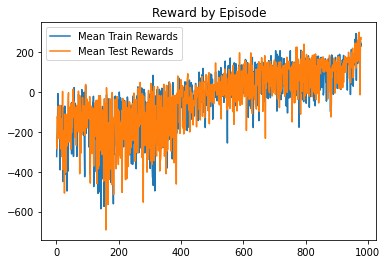

In [34]:
x = list(range(1, len(train_rewards)+1))
plt.plot(x, train_rewards, label='Mean Train Rewards')
plt.plot(x, test_rewards, label='Mean Test Rewards')
plt.legend()
plt.title('Reward by Episode')
plt.show()

In [44]:
_, frames = evaluate(test_env, policy, return_frames=True)

See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "



In [45]:

clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(frames, fps=50)
ipython_display(clip)

100%|██████████| 1000/1000 [00:02<00:00, 370.41it/s]
